# Modeling and Simulation in Python

Chapter 5

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Reading data

Pandas is a library that provides tools for reading and processing data.  `read_html` reads a web page from a file or the Internet and creates one `DataFrame` for each table on the page.

In [2]:
from pandas import read_html

The data directory contains a downloaded copy of https://en.wikipedia.org/wiki/World_population_estimates

The arguments of `read_html` specify the file to read and how to interpret the tables in the file.  The result, `tables`, is a sequence of `DataFrame` objects; `len(tables)` reports the length of the sequence.

In [3]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
len(tables)

6

We can select the `DataFrame` we want using the bracket operator.  The tables are numbered from 0, so `tables[2]` is actually the third table on the page.

`head` selects the header and the first five rows.

In [4]:
table2 = tables[2]
table2.head()

,United States Census Bureau (2017)[28],Population Reference Bureau (1973–2016)[15],United Nations Department of Economic and Social Affairs (2015)[16],Maddison (2008)[17],HYDE (2007)[24],Tanton (1994)[18],Biraben (1980)[19],McEvedy & Jones (1978)[20],Thomlinson (1975)[21],Durand (1974)[22],Clark (1967)[23]
Year,,,,,,,,,,,
1950,2557628654,2.516000e+09,2.525149e+09,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2.572851e+09,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2.619292e+09,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2.665865e+09,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2.713172e+09,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`tail` selects the last five rows.

In [5]:
table2.tail()

,United States Census Bureau (2017)[28],Population Reference Bureau (1973–2016)[15],United Nations Department of Economic and Social Affairs (2015)[16],Maddison (2008)[17],HYDE (2007)[24],Tanton (1994)[18],Biraben (1980)[19],McEvedy & Jones (1978)[20],Thomlinson (1975)[21],Durand (1974)[22],Clark (1967)[23]
Year,,,,,,,,,,,
2012,7013871313,7.057075e+09,7.080072e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,7092128094,7.136796e+09,7.162119e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,7169968185,7.238184e+09,7.243784e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,7247892788,7.336435e+09,7.349472e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,7325996709,7.418152e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Long column names are awkard to work with, but we can replace them with abbreviated names.

In [6]:
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

Here's what the DataFrame looks like now.  

In [7]:
table2.head()

,census,prb,un,maddison,hyde,tanton,biraben,mj,thomlinson,durand,clark
Year,,,,,,,,,,,
1950,2557628654,2.516000e+09,2.525149e+09,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2.572851e+09,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2.619292e+09,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2.665865e+09,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2.713172e+09,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first column, which is labeled `Year`, is special.  It is the **index** for this `DataFrame`, which means it contains the labels for the rows.

Some of the values use scientific notation; for example, `2.544000e+09` is shorthand for $2.544 \cdot 10^9$ or 2.544 billion.

`NaN` is a special value that indicates missing data.

### Series

We can use dot notation to select a column from a `DataFrame`.  The result is a `Series`, which is like a `DataFrame` with a single column.

In [8]:
census = table2.census
census.head()

Year
1950    2557628654
1951    2594939877
1952    2636772306
1953    2682053389
1954    2730228104
Name: census, dtype: int64

In [9]:
census.tail()

Year
2012    7013871313
2013    7092128094
2014    7169968185
2015    7247892788
2016    7325996709
Name: census, dtype: int64

Like a `DataFrame`, a `Series` contains an index, which labels the rows.

`1e9` is scientific notation for $1 \cdot 10^9$ or 1 billion.

From here on, we will work in units of billions.

In [10]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [11]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

Here's what these estimates look like.

Saving figure to file figs/chap03-fig01.pdf


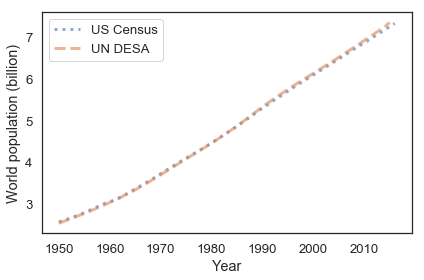

In [12]:
plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
    
decorate(xlabel='Year',
         ylabel='World population (billion)')
savefig('figs/chap03-fig01.pdf')

The following expression computes the elementwise differences between the two series, then divides through by the UN value to produce [relative errors](https://en.wikipedia.org/wiki/Approximation_error), then finds the largest element.

So the largest relative error between the estimates is about 1.3%.

In [13]:
max(abs(census - un) / un) * 100

1.3821293828998855

**Exercise:** Break down that expression into smaller steps and display the intermediate results, to make sure you understand how it works.

1.  Compute the elementwise differences, `census - un`
2.  Compute the absolute differences, `abs(census - un)`
3.  Compute the relative differences, `abs(census - un) / un`
4.  Compute the percent differences, `abs(census - un) / un * 100`


In [15]:
dif = census - un;

In [17]:
abs_dif = abs(dif);

In [19]:
rel_dif = abs_dif / un;

In [21]:
percent_dif = rel_dif * 100;

`max` and `abs` are built-in functions provided by Python, but NumPy also provides version that are a little more general.  When you import `modsim`, you get the NumPy versions of these functions.

### Constant growth

We can select a value from a `Series` using bracket notation.  Here's the first element:

In [22]:
census[1950]

2.557628654

And the last value.

In [23]:
census[2016]

7.325996709

But rather than "hard code" those dates, we can get the first and last labels from the `Series`:

In [24]:
t_0 = get_first_label(census)

1950

In [25]:
t_end = get_last_label(census)

2016

In [26]:
elapsed_time = t_end - t_0

66

And we can get the first and last values:

In [27]:
p_0 = get_first_value(census)

2.557628654

In [28]:
p_end = get_last_value(census)

7.325996709

Then we can compute the average annual growth in billions of people per year.

In [29]:
total_growth = p_end - p_0

4.768368055

In [30]:
annual_growth = total_growth / elapsed_time

0.07224800083333333

### TimeSeries

Now let's create a `TimeSeries` to contain values generated by a linear growth model.

In [31]:
results = TimeSeries()

,values


Initially the `TimeSeries` is empty, but we can initialize it so the starting value, in 1950, is the 1950 population estimated by the US Census.

In [32]:
results[t_0] = census[t_0]
results

,values
1950,2.557629


After that, the population in the model grows by a constant amount each year.

In [34]:
help(linrange)

Help on function linrange in module modsim:

linrange(start=0, stop=None, step=1, **options)
    Returns an array of evenly-spaced values in the interval [start, stop].
    
    This function works best if the space between start and stop
    is divisible by step; otherwise the results might be surprising.
    
    By default, the last value in the array is `stop-step`
    (at least approximately).
    If you provide the keyword argument `endpoint=True`,
    the last value in the array is `stop`.
    
    start: first value
    stop: last value
    step: space between values
    
    Also accepts the same keyword arguments as np.linspace.  See
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html
    
    returns: array or Quantity



In [37]:
for t in linrange(t_0, t_end):
    results[t+1] = results[t] + annual_growth

Here's what the results looks like, compared to the actual data.

Saving figure to file figs/chap03-fig02.pdf


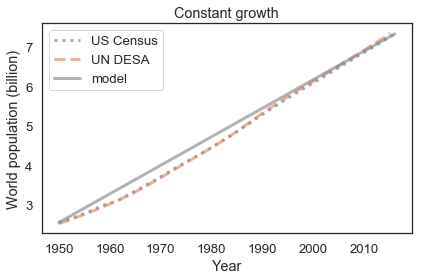

In [38]:
plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
plot(results, color='gray', label='model')

decorate(xlabel='Year', 
         ylabel='World population (billion)',
         title='Constant growth')
savefig('figs/chap03-fig02.pdf')

The model fits the data pretty well after 1990, but not so well before.

### Exercises

**Optional Exercise:**  Try fitting the model using data from 1970 to the present, and see if that does a better job.

Hint: 

1. Copy the code from above and make a few changes.  Test your code after each small change.

2. Make sure your `TimeSeries` starts in 1950, even though the estimated annual growth is based on later data.

3. You might want to add a constant to the starting value to match the data better.

Saving figure to file figs/chap03-fig02.pdf


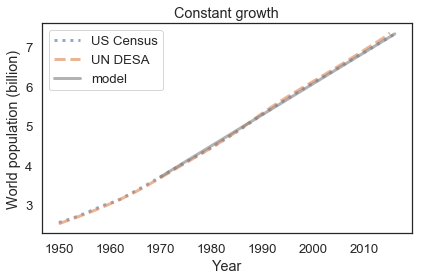

In [42]:
results = TimeSeries()
results[1970] = census[1970]

total_growth = census[t_end] - census[1970]
annual_growth = total_growth / (t_end - 1970)

for t in linrange(1970, t_end):
    results[t+1] = results[t] + annual_growth

plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
plot(results, color='gray', label='model')

decorate(xlabel='Year', 
         ylabel='World population (billion)',
         title='Constant growth')
savefig('figs/chap03-fig02.pdf')